In [17]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset

from sif import compute_word_frequencies, compute_sif_weights, compute_sif_embeddings, remove_pc_sif
from similarity import min_max_scale, calculate_similarity
from glove import download_glove, load_glove_vectors
from prepare_data import preprocess_text

In [2]:
ds = load_dataset("mteb/stsbenchmark-sts")
glove_vectors = load_glove_vectors("../data/raw/glove.6B.50d.txt")

In [3]:
df_sts = ds["train"].data.to_pandas()

In [4]:
df_sts['sentence1'] = preprocess_text(df_sts['sentence1'])
df_sts['sentence2'] = preprocess_text(df_sts['sentence2'])

In [5]:
sentences = df_sts[['sentence1', 'sentence2']].values.flatten().tolist()

In [6]:
word_freq = compute_word_frequencies(sentences)

In [30]:
len(sentences), len(word_freq), len(df_sts)

(11498, 10860, 5749)

In [7]:
sif_weights = compute_sif_weights(word_freq)

In [8]:
corpus = [df_sts['sentence1'].tolist(), df_sts['sentence2'].tolist()]

In [9]:
embeddings1 = compute_sif_embeddings(corpus[0], glove_vectors, sif_weights)
embeddings2 = compute_sif_embeddings(corpus[1], glove_vectors, sif_weights)


In [11]:
embeddings1_pc_removed = remove_pc_sif(embeddings1)
embeddings2_pc_removed = remove_pc_sif(embeddings2)

In [33]:
similarities = [cosine_similarity(embeddings1_pc_removed[i].reshape(1, -1), 
                                  embeddings2_pc_removed[i].reshape(1, -1))[0][0] 
                for i in range(len(df_sts))]

# Apply min-max scaling to similarities
scaled_similarities = minmax_scale(similarities)

# Add calculated similarities to the dataframe
df_sts['calculated_similarity'] = scaled_similarities

In [34]:
df_sts

,split,genre,dataset,year,sid,score,sentence1,sentence2,calculated_similarity
0,train,main-captions,MSRvid,2012test,0001,5.00,"[plane, taking]","[air, plane, taking]",0.820031
1,train,main-captions,MSRvid,2012test,0004,3.80,"[man, playing, large, flute]","[man, playing, flute]",0.660681
2,train,main-captions,MSRvid,2012test,0005,3.80,"[man, spreading, shreded, cheese, pizza]","[man, spreading, shredded, cheese, uncooked, p...",0.779396
3,train,main-captions,MSRvid,2012test,0006,2.60,"[three, men, playing, chess]","[two, men, playing, chess]",0.737490
4,train,main-captions,MSRvid,2012test,0009,4.25,"[man, playing, cello]","[man, seated, playing, cello]",0.587742
...,...,...,...,...,...,...,...,...,...
5744,train,main-news,headlines,2016,1456,0.00,"[severe, gales, storm, clodagh, hits, britain]","[merkel, pledges, nato, solidarity, latvia]",0.688276
5745,train,main-news,headlines,2016,1465,0.00,"[dozens, egyptians, hostages, taken, libyan, t...","[egyptian, boat, crash, death, toll, rises, bo...",0.626804
5746,train,main-news,headlines,2016,1466,0.00,"[president, heading, bahrain]","[president, xi, china, continue, help, fight, ...",0.615436
5747,train,main-news,headlines,2016,1470,0.00,"[china, india, vow, bilateral, ties]","[china, scrambles, reassure, jittery, stock, t...",0.448261


Pearson correlation between actual scores and calculated similarities: 0.010369615381274585
Spearman correlation between actual scores and calculated similarities: 0.011476911668240018


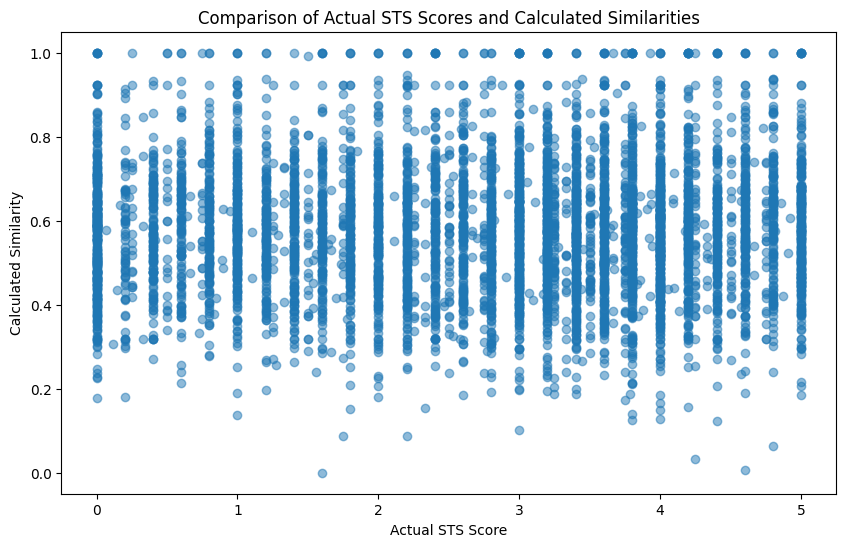

In [35]:
correlation = np.corrcoef(df_sts['score'], df_sts['calculated_similarity'])[0, 1]
print(f'Pearson correlation between actual scores and calculated similarities: {correlation}')

# Calculate Spearman correlation
from scipy import stats
spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['calculated_similarity'])
print(f'Spearman correlation between actual scores and calculated similarities: {spearman_corr}')

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.scatter(df_sts['score'], df_sts['calculated_similarity'], alpha=0.5)
plt.xlabel('Actual STS Score')
plt.ylabel('Calculated Similarity')
plt.title('Comparison of Actual STS Scores and Calculated Similarities')
plt.show()

In [ ]:
# Calculate a simple baseline using average word embeddings
def average_word_vectors(sentence, word_vectors):
    words = sentence.split()
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)  # Assuming 300d vectors

baseline_embeddings1 = df_sts['sentence1'].apply(lambda x: average_word_vectors(x, word_vectors))
baseline_embeddings2 = df_sts['sentence2'].apply(lambda x: average_word_vectors(x, word_vectors))

baseline_similarities = [cosine_similarity(baseline_embeddings1[i].reshape(1, -1), 
                                           baseline_embeddings2[i].reshape(1, -1))[0][0] 
                         for i in range(len(df_sts))]

baseline_correlation = np.corrcoef(df_sts['score'], baseline_similarities)[0, 1]
print(f'Baseline correlation: {baseline_correlation}')